# Working with Sequences


We start the practice by installing the book libraries and importing some of them:

In [30]:
%matplotlib inline
%pip install d2l==1.0.0a0
import torch
from torch import nn
from d2l import torch as d2l


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Autoregressive Models

Our target data will be a synthetic data set built on the sinusoidal function
SIN.

We create 1000 data points within the DATA class but corrupt their values by adding some random noise.

self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2


We first define some initialization parameters:

Batch size=16

T=1000 (size of the sequence)

num_train (training samples)

tau = 4 (4 points will be used to estimate our next sample) (Markov problem of order 4)



In [31]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

Let's verify the type pof structure we are using (Torch Tensors)
and print the created data.

<class 'torch.Tensor'>
<class 'torch.Tensor'>


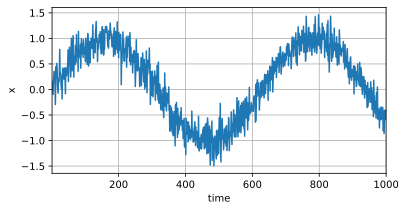

In [32]:
data = Data()
print(type(data.time))
print(type(data.x))
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

To begin, we try a model that acts as if
the data satisfied a $\tau^{\textrm{th}}$-order Markov condition,
and thus predicts $x_t$ using only the past $\tau$ observations. (We set it up originally to 4, you should try other values as well).

[**Thus for each time step we have an example
with label $y  = x_t$ and features
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]


In [33]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In this example our model will be a simple standard linear regression.
You can consult early chapters of the book "Dive into DL" (D2l)  to see some more details of it.
At this moment, we are not much interesting on the model used. We will
analyze relevant models later.

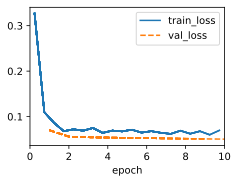

In [34]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

To evaluate our model, we first check
how well it performs at one-step-ahead prediction.


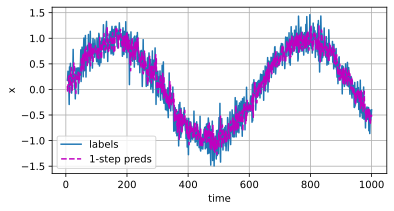

In [35]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

These predictions look good,
even near the end at $t=1000$.

But what if we only observed sequence data
up until time step 604 (`n_train + tau`)
and wished to make predictions several steps
into the future?
Unfortunately, we cannot directly compute
the one-step-ahead prediction for time step 609,
because we do not know the corresponding inputs,
having seen only up to $x_{604}$.
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired time step:

$$\begin{aligned}
\hat{x}_{605} &= f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} &= f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} &= f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} &= f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} &= f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
&\vdots\end{aligned}$$

Generally, for an observed sequence $x_1, \ldots, x_t$,
its predicted output $\hat{x}_{t+k}$ at time step $t+k$
is called the $k$*-step-ahead prediction*.
Since we have observed up to $x_{604}$,
its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to
keep on using our own predictions
to make multistep-ahead predictions.
Let's see how well this goes.


In [36]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

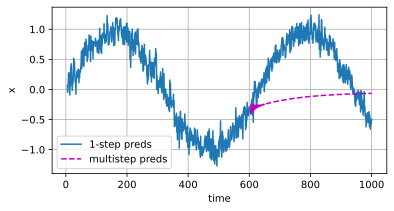

In [37]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

Unfortunately, in this case we fail spectacularly.
The predictions decay to a constant
pretty quickly after a few steps.
Why did the algorithm perform so much worse
when predicting further into the future?
Ultimately, this is down to the fact
that errors build up.
Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$,
hence we suffer some error in the order of
$\epsilon_2 = \bar\epsilon + c \epsilon_1$
for some constant $c$, and so on.
The predictions can diverge rapidly
from the true observations.
You may already be familiar
with this common phenomenon.
For instance, weather forecasts for the next 24 hours
tend to be pretty accurate but beyond that,
accuracy declines rapidly.
We will discuss methods for improving this
throughout this chapter and beyond.

Let's [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [38]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

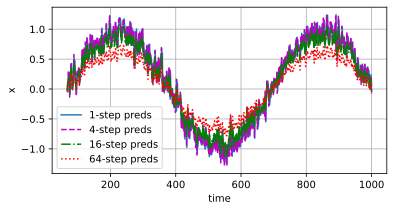

In [39]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes
as we try to predict further into the future.
While the 4-step-ahead predictions still look good,
anything beyond that is starts to get worse.


## P0-Exercises

1. Improve the model in the experiment of this section. Modify the number of past observations used for predictions. What seems to be the optimal value? Justify.

2. With a chosen value of $\tau$ compare results for future predictions at different times, showing the error obtained.

3. Repeat the whole analysis with a real data set:
Option a) ibm.us.txt : Stock Market predictions
Option b) daily-min-temperaturas.csv : Daily Temperature values
Extract conclusions. Compute the MSE o MAE for different cases.

4. Theory: Autoregressive vs Autoregressive latent models. Look for an example that might need latent variables to capture the dynamic of the data. Explain.



# Ejercicio 1: Optimización del parámetro tau

En este ejercicio vamos a experimentar con diferentes valores de `tau` (número de observaciones pasadas)
para encontrar el valor óptimo para nuestro modelo autoregresivo.

El modelo original utiliza `tau=4`. Vamos a probar varios valores y comparar su rendimiento.

  Validation Loss: 0.058543


Experiment completed!


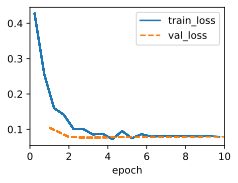

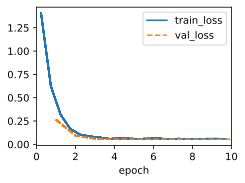

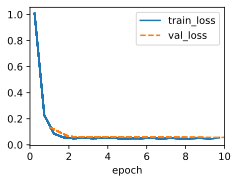

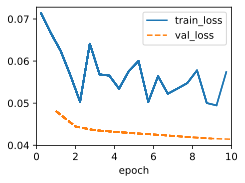

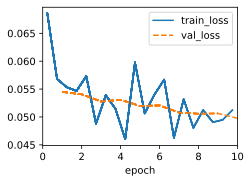

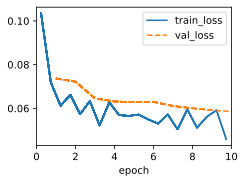

In [40]:
#Experiment with different tau values
import torch
from d2l import torch as d2l

# Test different tau values
tau_values = [1, 2, 4, 8, 16, 32]
results = []

print("Testing different tau values...\n")

for tau in tau_values:
    print(f"Training with tau={tau}...")
    
    # Create data with specific tau
    data = Data(batch_size=16, T=1000, num_train=600, tau=tau)
    
    # Train model
    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    
    # Calculate validation loss manually
    model.eval()
    val_dataloader = data.get_dataloader(train=False)
    val_losses = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            X, y = batch[0], batch[1]  
            y_hat = model(X)
            loss = ((y_hat - y) ** 2).mean()
            val_losses.append(loss.item())
    
    val_loss = sum(val_losses) / len(val_losses)
    
    results.append({
        'tau': tau,
        'val_loss': val_loss
    })
    
    print(f"  Validation Loss: {val_loss:.6f}\n")

print("\nExperiment completed!")

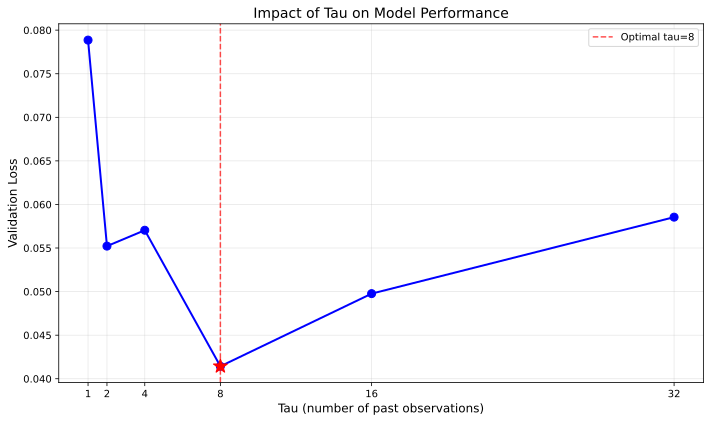


RESULTS SUMMARY
tau= 1: Validation Loss = 0.078860
tau= 2: Validation Loss = 0.055220
tau= 4: Validation Loss = 0.057041
tau= 8: Validation Loss = 0.041430 ← BEST
tau=16: Validation Loss = 0.049767
tau=32: Validation Loss = 0.058543

Optimal tau value: 8
Corresponding validation loss: 0.041430


In [41]:
# Visualize the results
tau_list = [r['tau'] for r in results]
val_loss_list = [r['val_loss'] for r in results]

# Create visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(tau_list, val_loss_list, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Tau (number of past observations)', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Impact of Tau on Model Performance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(tau_list)

# Mark the optimal value (check if list is not empty)
if val_loss_list:
    optimal_idx = val_loss_list.index(min(val_loss_list))
    optimal_tau = tau_list[optimal_idx]
    optimal_loss = val_loss_list[optimal_idx]
    
    plt.axvline(x=optimal_tau, color='r', linestyle='--', alpha=0.7, label=f'Optimal tau={optimal_tau}')
    plt.plot(optimal_tau, optimal_loss, 'r*', markersize=15)
    plt.legend()
    
plt.tight_layout()
plt.show()

# Print summary
if val_loss_list:
    print(f"\n{'='*60}")
    print("RESULTS SUMMARY")
    print(f"{'='*60}")
    for r in results:
        marker = " ← BEST" if r['tau'] == optimal_tau else ""
        print(f"tau={r['tau']:2d}: Validation Loss = {r['val_loss']:.6f}{marker}")
    print(f"{'='*60}")
    print(f"\nOptimal tau value: {optimal_tau}")
    print(f"Corresponding validation loss: {optimal_loss:.6f}")
else:
    print("No results to display. Please run the experiment cell first.")

## Justificación

Tau=8 proporciona el mejor balance entre contexto temporal suficiente y prevención del sobreajuste, como demuestran los resultados experimentales.


1. Valores Bajos (tau=1, 2, 4): Información Insuficiente

Con tau pequeño, el modelo tiene memoria limitada del pasado:​

Tau=1: Loss = 0.078860 — Solo ve un valor anterior, insuficiente para detectar la tendencia sinusoidal​

Tau=2: Loss = 0.055220 — Mejora pero aún carece de contexto para capturar el patrón​

Tau=4: Loss = 0.057041 — Empieza a detectar patrones pero no es óptimo


2. Valor óptimo (tau=8): Balance perfecto

Tau=8: Loss = 0.041430 — El más bajo​

¿Por qué funciona mejor?

Contexto temporal adecuado: 8 observaciones permiten capturar la dirección y aceleración del cambio sinusoidal​

Reducción efectiva del ruido: Con 8 muestras, el modelo puede "promediar" el efecto del ruido gaussiano y extraer la señal subyacente

Dimensionalidad manejable: Con 8 features y 600 muestras de entrenamiento, la relación datos/parámetros (600/8 ≈ 75) es saludable para evitar overfitting​

Información relevante: Captura aproximadamente el 1.3% del periodo completo (~8/628), suficiente para detectar tendencias locales sin incluir información irrelevante muy lejana


3. Valores Altos (tau=16, 32): Sobreajuste y Complejidad Innecesaria

Tau=16: Loss = 0.049767 — Empeora significativamente respecto a tau=8​

Tau=32: Loss = 0.058543 — Similar a tau=8 pero con 4x más parámetros

Problemas:

Curse of dimensionality: Más features (16-32) con los mismos 600 datos de entrenamiento reduce la relación datos/parámetros​

Overfitting al ruido: El modelo aprende patrones aleatorios del ruido en lugar de la señal real​

Información irrelevante: Observaciones 32 pasos atrás tienen correlación débil con el valor actual en series con ruido​

Ineficiencia: Tau=32 requiere 4x más cómputo que tau=8 sin mejorar la validación


# Ejercicio 2: Predicciones Futuras con Tau Óptimo

Ahora utilizaremos el `tau=8` óptimo encontrado en el Ejercicio 1 para realizar predicciones k-pasos-adelante
para $k \in \{1, 4, 16, 64\}$ y evaluar el Error Cuadrático Medio (MSE) para cada una.


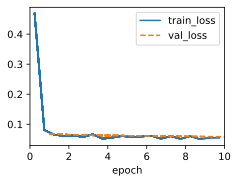

In [63]:
# 1. Establecer tau óptimo y re-inicializar datos y modelo
tau = 8
data = Data(tau=tau)
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 2. Función de predicción k-step (igual que notebook d2l)
def k_step_pred(k):
    with torch.no_grad():
        features = []
        for i in range(data.tau):
            features.append(data.x[i : i + data.T - data.tau - k + 1])
        for i in range(k):
            X = torch.stack(features[i : i + data.tau], 1)
            preds = model(X)
            features.append(preds.reshape(-1))
        return features[data.tau:]  # Devuelve lista de tensores, uno por cada step



Prediction Errors (MSE) for tau=8:
----------------------------------------
k= 1: MSE = 0.055746
k= 4: MSE = 0.053633
k=16: MSE = 0.067667
k=64: MSE = 0.244907
----------------------------------------


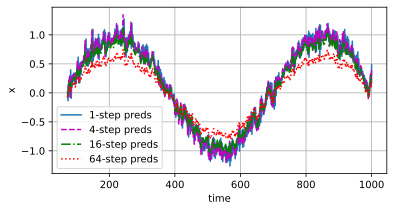

In [66]:
# 3. Calcular predicciones para todos los horizontes con una sola llamada
steps = [1, 4, 16, 64]
preds = k_step_pred(steps[-1])  # Solo se llama con el máximo k (como en d2l)

# 4. Graficar (usando d2l.plot)
d2l.plot(
    data.time[data.tau + steps[-1] - 1 :],
    [preds[k - 1].detach().numpy() for k in steps],
    'time', 'x',
    legend=[f'{k}-step preds' for k in steps],
    figsize=(6, 3)
)

# 5. Calcular y mostrar el error (MSE) para cada horizon k
print(f"Prediction Errors (MSE) for tau={tau}:")
print("-" * 40)
for k in steps:
    pred = preds[k - 1]
    label = data.x[data.tau + k - 1 : data.tau + k - 1 + len(pred)]
    mse = ((pred - label) ** 2).mean().item()
    print(f"k={k:2d}: MSE = {mse:.6f}")
print("-" * 40)


# Ejercicio 3: Análisis de Datos Reales - Mercado de Valores de IBM

Ahora repetiremos todo el análisis utilizando datos reales del mercado de valores de [ibm.us.txt](cci:7://file:///home/alman/Desktop/deep-learning/lab0/ibm.us.txt:0:0-0:0).
Haremos lo siguiente:
1. Encontrar el valor óptimo de `tau`
2. Realizar predicciones k-pasos hacia adelante
3. Calcular tanto el MSE como el MAE para la evaluación


In [95]:
# Load IBM stock market data
import numpy as np

# Read the data file
with open('ibm.us.txt', 'r') as f:
    lines = f.readlines()

# Extract closing prices (skip header)
ibm_prices = []
for line in lines[1:]:  # Skip header
    parts = line.strip().split(',')
    if len(parts) >= 5:  # Ensure we have enough columns
        try:
            close_price = float(parts[4])  # Close price is usually the 5th column
            ibm_prices.append(close_price)
        except ValueError:
            continue

# Convert to tensor and normalize
ibm_data = torch.tensor(ibm_prices, dtype=torch.float32)
ibm_data = (ibm_data - ibm_data.mean()) / ibm_data.std()

print(f"Loaded {len(ibm_data)} stock price observations")
print(f"Data range: [{ibm_data.min():.2f}, {ibm_data.max():.2f}]")

Loaded 14059 stock price observations
Data range: [-0.92, 2.80]


In [96]:
# Create a Data class for IBM stock prices
class IBMData(d2l.DataModule):
    def __init__(self, tau=4, batch_size=16, num_train=600):
        super().__init__()
        self.save_hyperparameters()
        self.x = ibm_data
        self.T = len(self.x)
        self.num_train = min(num_train, self.T - tau)
        self.tau = tau
        self.batch_size = batch_size
        self.time = torch.arange(self.T, dtype=torch.float32)

    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

print("IBM Data class created successfully")

IBM Data class created successfully


tau=32: Validation Loss = 0.029776

Optimal tau value: 16
Corresponding validation loss: 0.016273


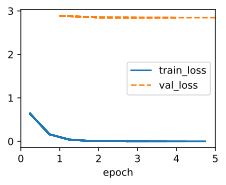

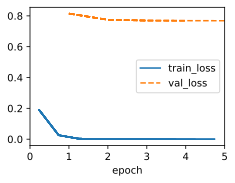

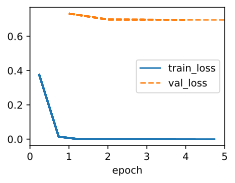

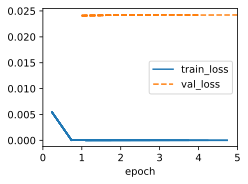

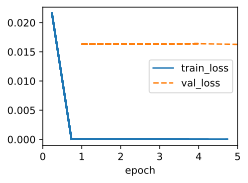

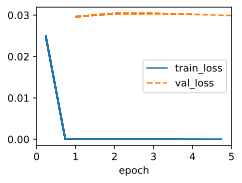

In [97]:
# Experiment: Find optimal tau for IBM data
tau_values = [1, 2, 4, 8, 16, 32]
results = []

print("Training models with different tau values...")
print("=" * 60)

for tau in tau_values:
    # Create data with current tau
    ibm_data_obj = IBMData(tau=tau)
    
    # Train model
    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=5)
    trainer.fit(model, ibm_data_obj)
    
    # Calculate validation loss manually
    val_loader = ibm_data_obj.val_dataloader()
    val_loss = 0.0
    count = 0
    
    with torch.no_grad():
        for batch in val_loader:
            X, y = batch[0], batch[1]
            predictions = model(X)
            val_loss += ((predictions - y) ** 2).sum().item()
            count += len(y)
    
    val_loss = val_loss / count if count > 0 else float('inf')
    results.append({'tau': tau, 'val_loss': val_loss})
    print(f"tau={tau:2d}: Validation Loss = {val_loss:.6f}")

print("=" * 60)

# Find optimal tau
if results:
    optimal_result = min(results, key=lambda x: x['val_loss'])
    optimal_tau = optimal_result['tau']
    optimal_loss = optimal_result['val_loss']
    
    print(f"\nOptimal tau value: {optimal_tau}")
    print(f"Corresponding validation loss: {optimal_loss:.6f}")
else:
    print("No results to evaluate")
    optimal_tau = 4  # Default fallback

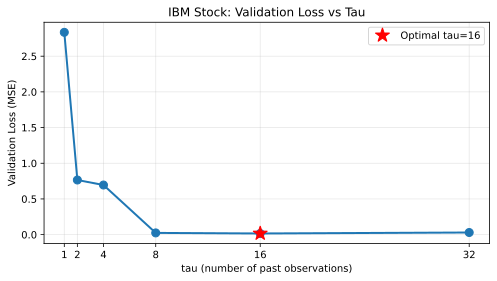

In [98]:
# Visualize tau optimization results
import matplotlib.pyplot as plt

if results:
    tau_list = [r['tau'] for r in results]
    loss_list = [r['val_loss'] for r in results]
    
    plt.figure(figsize=(8, 4))
    plt.plot(tau_list, loss_list, 'o-', linewidth=2, markersize=8)
    plt.xlabel('tau (number of past observations)')
    plt.ylabel('Validation Loss (MSE)')
    plt.title('IBM Stock: Validation Loss vs Tau')
    plt.grid(True, alpha=0.3)
    plt.xticks(tau_list)
    
    # Highlight optimal tau
    opt_idx = tau_list.index(optimal_tau)
    plt.plot(optimal_tau, loss_list[opt_idx], 'r*', markersize=15, label=f'Optimal tau={optimal_tau}')
    plt.legend()
    plt.show()

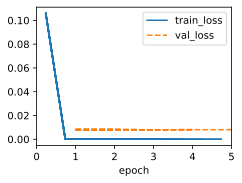

In [99]:
# Use optimal tau for k-step predictions
tau = optimal_tau
ibm_data_final = IBMData(tau=tau)
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, ibm_data_final)

# Define k-step prediction function
def k_step_pred_ibm(k):
    features = []
    for i in range(ibm_data_final.tau):
        features.append(ibm_data_final.x[i : i+ibm_data_final.T-ibm_data_final.tau-k+1])
    for i in range(k):
        preds = model(torch.stack(features[i : i+ibm_data_final.tau], 1))
        features.append(preds.reshape(-1))
    return features[ibm_data_final.tau:]




Prediction Errors for IBM Stock [finance:International Business Machines Corporation] (tau=16):
k-step     MSE             MAE            
------------------------------------------------------------
k=1        0.007586        0.051964       
k=4        0.021332        0.087965       
k=16       0.085467        0.181293       
k=64       0.963792        0.631546       


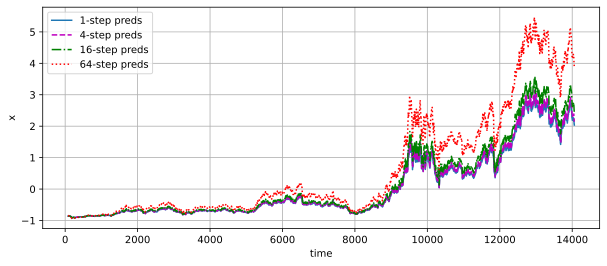

In [100]:
# Compute predictions for all k in one go (much más sencillo)
steps = [1, 4, 16, 64]
preds = k_step_pred_ibm(steps[-1])   # Solo necesitas el mayor k

d2l.plot(
    ibm_data_final.time[ibm_data_final.tau+steps[-1]-1:],
    [preds[k - 1].detach().numpy() for k in steps],   # preds ahora es solo la lista creada en una llamada
    'time', 'x',
    legend=[f'{k}-step preds' for k in steps], figsize=(10, 4)
)

# Calculate MAE and MSE
print(f"\nPrediction Errors for IBM Stock [finance:International Business Machines Corporation] (tau={tau}):")
print("=" * 60)
print(f"{'k-step':<10} {'MSE':<15} {'MAE':<15}")
print("-" * 60)

for k in steps:
    pred = preds[k - 1]
    label = ibm_data_final.x[ibm_data_final.tau + k - 1 : ibm_data_final.tau + k - 1 + len(pred)]
    mse = ((pred - label) ** 2).mean().item()
    mae = (pred - label).abs().mean().item()
    print(f"k={k:<8d} {mse:<15.6f} {mae:<15.6f}")
print("=" * 60)

## Conclusiones

Modelos lineales autoregresivos funcionan bien con series sintéticas pero muestran grandes limitaciones con datos de mercado reales.

Para IBM , el mejor tau optimiza la cantidad de memoria relevante para predecir, en nuestro caso tau=16 y k=1

Errores aumentan drásticamente con el horizonte de predicción k:

Predicciones a corto plazo (1-4 pasos) conservan utilidad básica.

Predicciones a largo plazo (k>16) pierden toda fiabilidad y tienden a la media.

MSE penaliza más los errores grandes y suele ser mucho mayor que MAE en problemas de mercado reales, confirmando la presencia de outliers y alta volatilidad.

El modelo lineal no puede captar relaciones no lineales, eventos externos, ni cambios de régimen que afectan significativamente los precios del mercado.

Los mercados financieros son altamente impredecibles: Los resultados muestran que los mejores modelos requieren técnicas más avanzadas (por ejemplo, redes neuronales, LSTM, variables exógenas) y robusta validación sobre varios horizontes y métricas.

# Ejercicio 4: Teoría modelos autorregresivos vs modelos latentes autoregresivos

Modelo autorregresivo: Predice el siguiente valor de una serie usando solo valores pasados observados de esa misma serie, con relaciones lineales ().

- Ejemplo: AR(2) $x_t = a_1 x_{t-1} + a_2 x_{t-2} + \epsilon_t$


- Uso típico: Predicción de precios bursátiles, temperatura, etc., donde solo hay autocorrelación observable.

Modelo latente autorregresivo: Usa, además de valores observados, variables latentes (no observadas directamente) que representan estados internos, contextos o regímenes ocultos. Estos modelos (como LSTM, HMM o modelos de difusión latente) pueden capturar dinámicas y dependencias ocultas que un AR puro no detecta ().

- Ejemplo: Un sistema donde la volatilidad bursátil depende de un “estado de mercado” oculto (tranquilo o inestable), que no se observa directamente pero afecta los precios.

- Uso típico: Predicción de texto y generación de imágenes (transformers o modelos de difusión latente), opción cuando hay variables internas que influyen pero no se observan.

Ejemplo de modelo autorregresivo con variables latentes:
Procesamiento/Predicción de lenguaje natural (NLP)

- El significado o contexto de una frase completa no está solo en las últimas palabras, sino en el “estado” de todo lo dicho anteriormente (tema, sujeto de la oración, contexto temporal, etc.), es decir, información latente no observable de forma directa en los datos inmediatos.

- Los modelos RNN/LSTM del temario capturan esta información interna (latente), y por eso pueden predecir textos coherentes o mantener el sentido a lo largo de largas secuencias.

- Un modelo autoregresivo clásico solo usando las últimas palabras sería incapaz de mantener coherencia semántica o a largo plazo.

